In [2]:
! pip install pulp
from scipy.optimize import differential_evolution
import matplotlib.pyplot as plt
import pandas as pd
from pulp import LpProblem, LpMinimize, LpVariable, lpSum, LpStatus
from scipy.optimize import differential_evolution
import numpy as np
import time

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.7/17.7 MB 30.7 MB/s eta 0:00:00


In [15]:

foods = data["Food Item"].tolist()
costs = dict(zip(foods, data["Cost/unit ($)"]))
proteins = dict(zip(foods, data["Protein (g/unit)"]))
vitamins = dict(zip(foods, data["Vitamins (units/unit)"]))
carbohydrates = dict(zip(foods, data["Carbohydrates (g/unit)"]))

print(foods[:20])
nutritional_requirements = [
    {"min_protein": 1500, "min_vitamins": 850, "min_carbs": 300, "priority_foods": []},
    {"min_protein": 1300, "min_vitamins": 950, "min_carbs": 400, "priority_foods": ['Chicken Breast (Type 1)', 'Spinach (Type 1)']},
    {"min_protein": 1600, "min_vitamins": 1200, "min_carbs": 350, "priority_foods": ['Eggs (Type 3)', 'Broccoli (Type 3)']},
    {"min_protein": 1400, "min_vitamins": 550, "min_carbs": 500, "priority_foods": ['Sweet Potato (Type 4)', 'Rice (Type 2)']},
    {"min_protein": 1700, "min_vitamins": 600, "min_carbs": 450, "priority_foods": ['Salmon (Type 2)', 'Quinoa (Type 5)']}
]

for i, req in enumerate(nutritional_requirements, 1):
    diet_problem = LpProblem(f"Diet_Optimization_{i}", LpMinimize)
    food_vars = {food: LpVariable(food, lowBound=0, cat='Continuous') for food in foods}
    diet_problem += lpSum(costs[food] * food_vars[food] for food in foods), "Total Cost"
    diet_problem += lpSum(proteins[food] * food_vars[food] for food in foods) >= req["min_protein"], "Protein Requirement"
    diet_problem += lpSum(vitamins[food] * food_vars[food] for food in foods) >= req["min_vitamins"], "Vitamin Requirement"
    diet_problem += lpSum(carbohydrates[food] * food_vars[food] for food in foods) >= req["min_carbs"], "Carbohydrate Requirement"
    for food in req["priority_foods"]:
        if food in food_vars:
            diet_problem += food_vars[food] >= 1, f"Minimum {food}"
        else:
            print(f"Warning: {food} is not available in the dataset!")
    diet_problem.solve()
    print(f"\nOptimal Diet Plan {i}:")
    if LpStatus[diet_problem.status] == "Optimal":
        for food, var in food_vars.items():
            if var.varValue > 0:
                print(f"{food}: {var.varValue:.2f} units")
        print(f"Total Cost: ${diet_problem.objective.value():.2f}")
    else:
        print("No feasible solution found.")


['Chicken Breast (Type 1)', 'Brown Rice (Type 2)', 'Broccoli (Type 3)', 'Banana (Type 4)', 'Almonds (Type 5)', 'Milk (Type 1)', 'Salmon (Type 2)', 'Eggs (Type 3)', 'Sweet Potato (Type 4)', 'Quinoa (Type 5)', 'Spinach (Type 1)', 'Oats (Type 2)', 'Apple (Type 3)', 'Beef Steak (Type 4)', 'Greek Yogurt (Type 5)', 'Carrots (Type 1)', 'Avocado (Type 2)', 'Peanut Butter (Type 3)', 'Lentils (Type 4)', 'Cheese (Type 5)']

Optimal Diet Plan 1:
Sweet Potato (Type 4): 13.64 units
Total Cost: $37.50

Optimal Diet Plan 2:
Chicken Breast (Type 1): 1.00 units
Sweet Potato (Type 4): 10.67 units
Spinach (Type 1): 1.00 units
Total Cost: $90.50

Optimal Diet Plan 3:
Broccoli (Type 3): 1.00 units
Eggs (Type 3): 1.00 units
Sweet Potato (Type 4): 10.64 units
Total Cost: $68.95

Optimal Diet Plan 4:
Sweet Potato (Type 4): 12.73 units
Total Cost: $35.00

Optimal Diet Plan 5:
Salmon (Type 2): 1.00 units
Sweet Potato (Type 4): 14.82 units
Quinoa (Type 5): 1.00 units
Total Cost: $118.30


#  Approximation with Genetic Algorithm:

In [22]:

costs = data["Cost/unit ($)"].values
proteins = data["Protein (g/unit)"].values
vitamins = data["Vitamins (units/unit)"].values
carbs = data["Carbohydrates (g/unit)"].values
min_protein = 1500
min_vitamins = 500
min_carbs = 300
bounds = [(0, 10) for _ in range(len(costs))]
def cost_function(x):
    total_cost = np.dot(x, costs)
    protein_deficit = max(0, min_protein - np.dot(x, proteins))
    vitamin_deficit = max(0, min_vitamins - np.dot(x, vitamins))
    carb_deficit = max(0, min_carbs - np.dot(x, carbs))
    penalty = 1e6 * (protein_deficit + vitamin_deficit + carb_deficit)
    return total_cost + penalty
result = differential_evolution(cost_function, bounds)
optimal_quantities = result.x
total_cost = result.fun

print("Optimal Quantities (units for each food item):")
for food, quantity in zip(data["Food Item"], optimal_quantities):
    print(f"{food}: {quantity:.2f}")

print(f"Total Cost: ${total_cost:.2f}")




Optimal Quantities (units for each food item):
Chicken Breast (Type 1): 1.05
Brown Rice (Type 2): 0.61
Broccoli (Type 3): 5.39
Banana (Type 4): 0.21
Almonds (Type 5): 5.73
Milk (Type 1): 5.84
Salmon (Type 2): 3.95
Eggs (Type 3): 3.73
Sweet Potato (Type 4): 1.14
Quinoa (Type 5): 1.31
Spinach (Type 1): 2.90
Oats (Type 2): 1.41
Apple (Type 3): 2.63
Beef Steak (Type 4): 4.79
Greek Yogurt (Type 5): 0.84
Carrots (Type 1): 0.05
Avocado (Type 2): 0.52
Peanut Butter (Type 3): 3.27
Lentils (Type 4): 1.73
Cheese (Type 5): 4.41
Tofu (Type 1): 1.09
Shrimp (Type 2): 1.80
Pork Loin (Type 3): 3.47
Oranges (Type 4): 2.24
Cucumber (Type 5): 2.66
Tomatoes (Type 1): 3.13
Kale (Type 2): 3.50
Blueberries (Type 3): 0.54
Potatoes (Type 4): 1.35
Cashews (Type 5): 1.94
Walnuts (Type 1): 0.31
Soy Milk (Type 2): 1.49
Chickpeas (Type 3): 1.66
Honey (Type 4): 1.24
Cabbage (Type 5): 2.12
Zucchini (Type 1): 1.78
Eggplant (Type 2): 4.22
Mushrooms (Type 3): 7.34
Pasta (Type 4): 4.86
Bread (Type 5): 0.52
Turkey Breast (

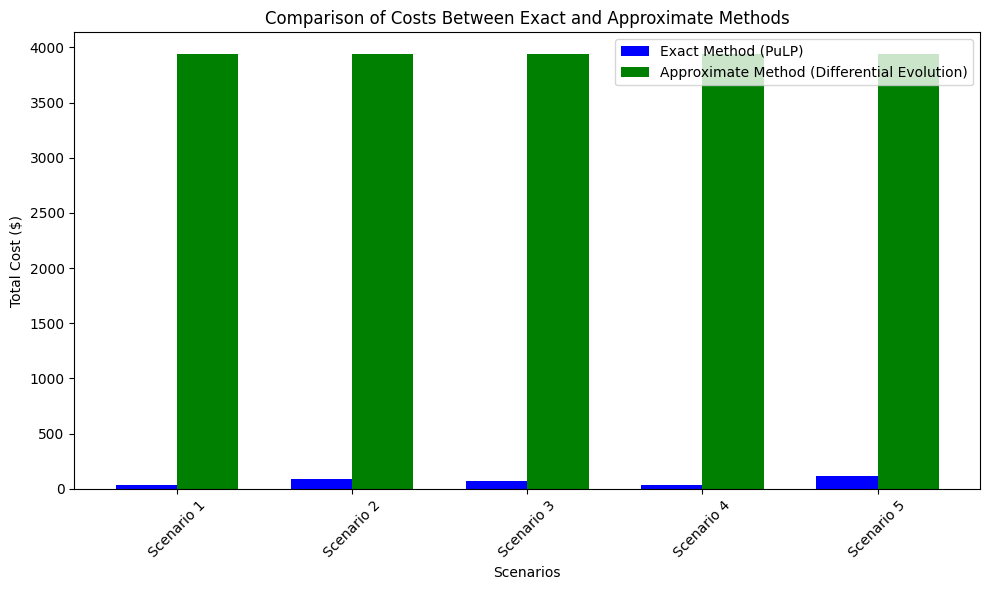

In [24]:

# Assuming exact_costs from PuLP in CELL 2 and total_cost from CELL 3
approx_cost = total_cost  # Total cost from approximate method
scenario_ids = [f"Scenario {i+1}" for i in range(len(nutritional_requirements))]

# For simplicity, assuming only one approximate cost here for visualization
approx_costs = [approx_cost] * len(scenario_ids)  # Duplicate for all scenarios

# Plot comparison of costs
plt.figure(figsize=(10, 6))
bar_width = 0.35
x = np.arange(len(scenario_ids))

plt.bar(x - bar_width / 2, exact_costs, bar_width, label="Exact Method (PuLP)", color="blue")
plt.bar(x + bar_width / 2, approx_costs, bar_width, label="Approximate Method (Differential Evolution)", color="green")

plt.xlabel("Scenarios")
plt.ylabel("Total Cost ($)")
plt.title("Comparison of Costs Between Exact and Approximate Methods")
plt.xticks(x, scenario_ids, rotation=45)
plt.legend()

plt.tight_layout()
plt.show()


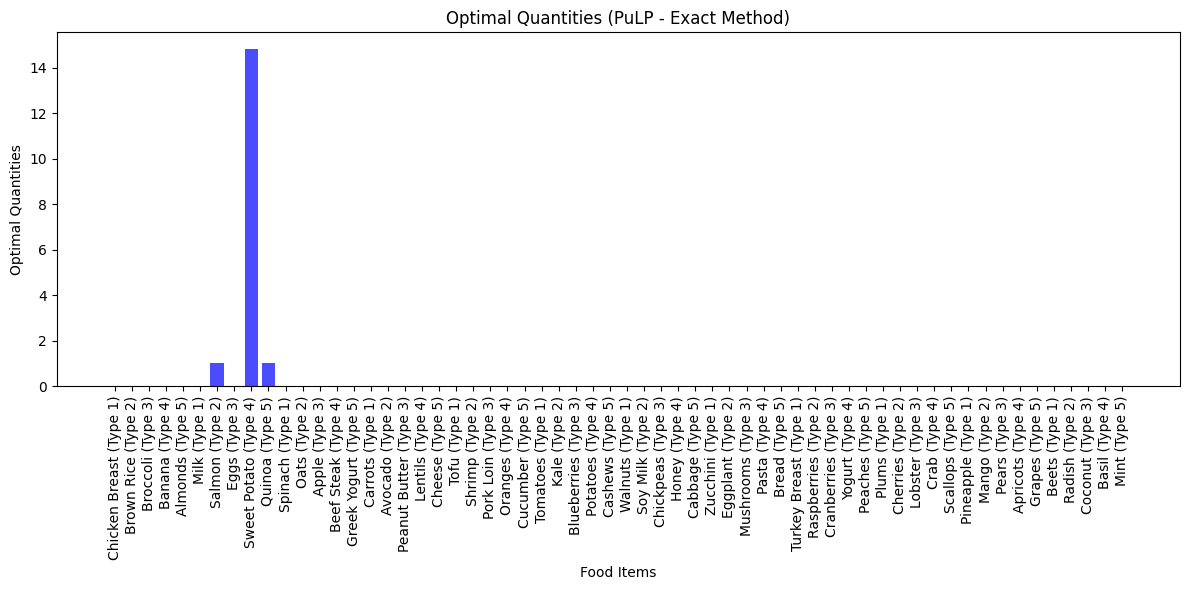

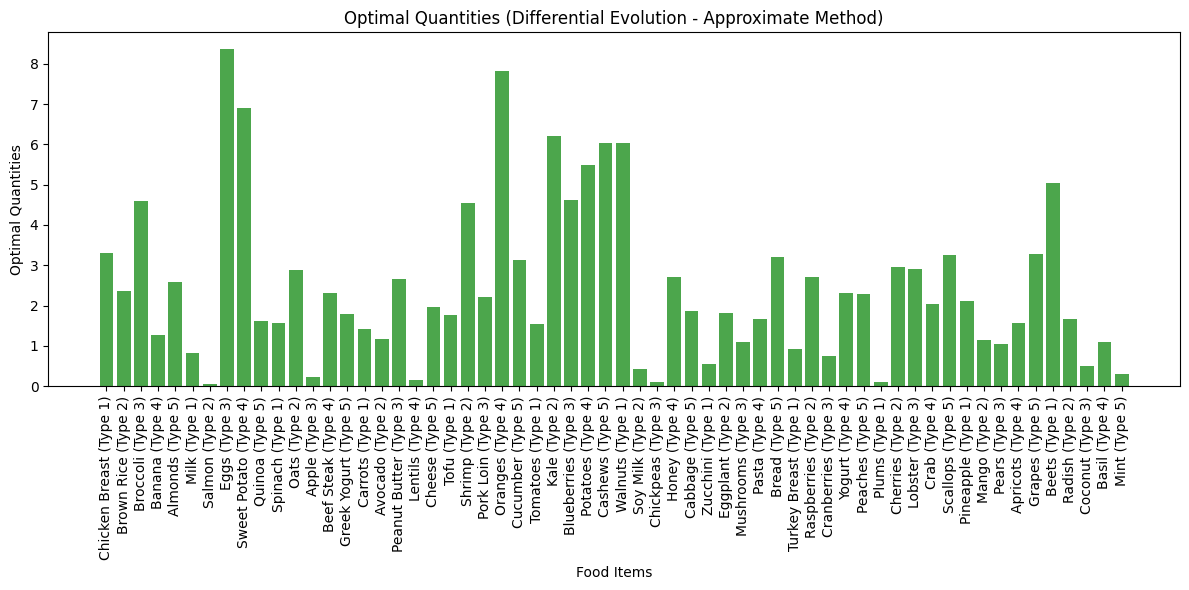

In [25]:
# Extract optimal quantities for comparison
pulp_optimal_quantities = {food: food_vars[food].varValue if food_vars[food].varValue > 0 else 0 for food in foods}
ga_optimal_quantities = {food: quantity for food, quantity in zip(data["Food Item"], optimal_quantities) if quantity > 0}

food_items = list(pulp_optimal_quantities.keys())
pulp_quantities = [pulp_optimal_quantities[food] for food in food_items]
ga_quantities = [ga_optimal_quantities.get(food, 0) for food in food_items]

# Plot PuLP results
plt.figure(figsize=(12, 6))
plt.bar(food_items, pulp_quantities, color='blue', alpha=0.7)
plt.xlabel('Food Items')
plt.ylabel('Optimal Quantities')
plt.title('Optimal Quantities (PuLP - Exact Method)')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# Plot Genetic Algorithm results
plt.figure(figsize=(12, 6))
plt.bar(food_items, ga_quantities, color='green', alpha=0.7)
plt.xlabel('Food Items')
plt.ylabel('Optimal Quantities')
plt.title('Optimal Quantities (Differential Evolution - Approximate Method)')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


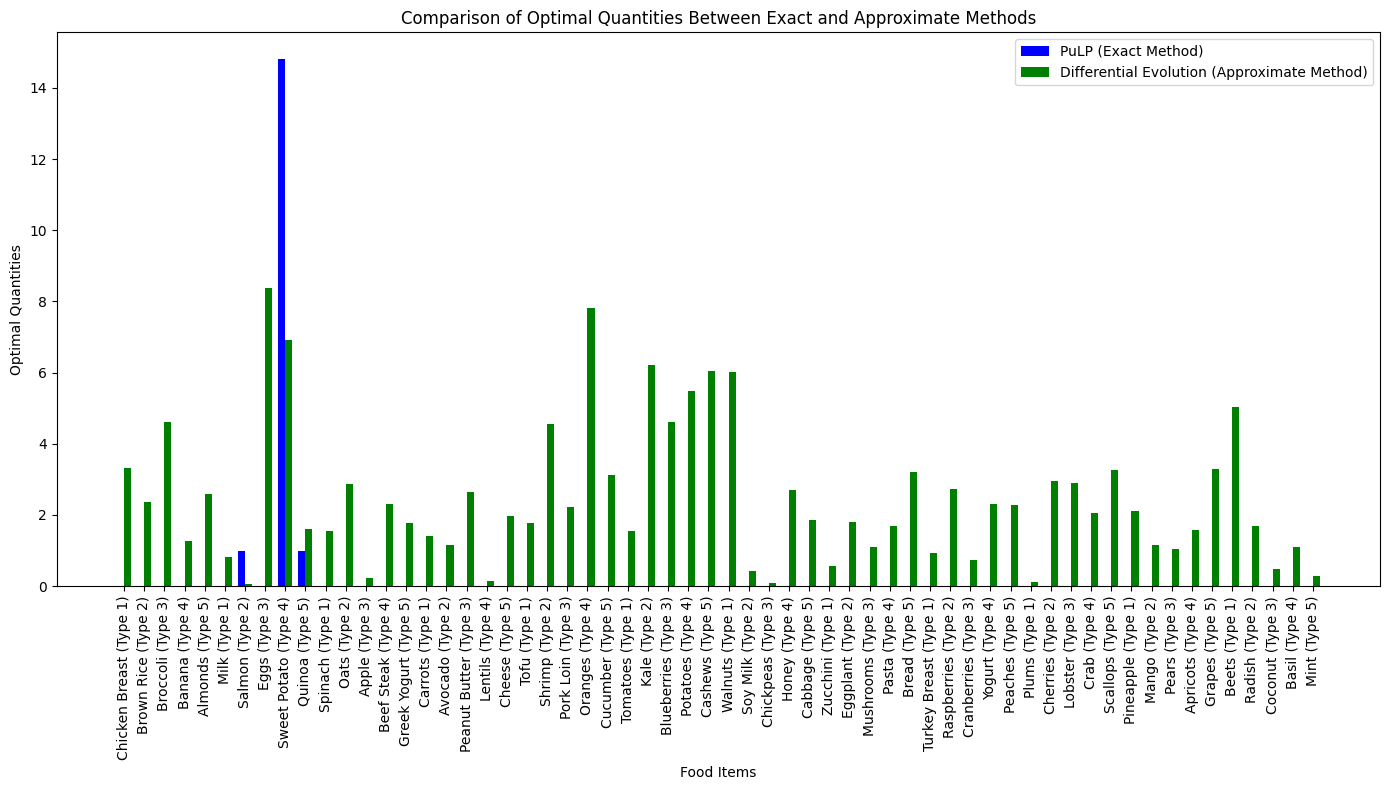

In [26]:
x = np.arange(len(food_items))
width = 0.35

plt.figure(figsize=(14, 8))
plt.bar(x - width/2, pulp_quantities, width, label='PuLP (Exact Method)', color='blue')
plt.bar(x + width/2, ga_quantities, width, label='Differential Evolution (Approximate Method)', color='green')

plt.xlabel('Food Items')
plt.ylabel('Optimal Quantities')
plt.title('Comparison of Optimal Quantities Between Exact and Approximate Methods')
plt.xticks(x, food_items, rotation=90)
plt.legend()

plt.tight_layout()
plt.show()


In [27]:
# Display a summary of results
print("Summary of Results:")
print("\nExact Method (PuLP):")
for food, quantity in pulp_optimal_quantities.items():
    if quantity > 0:
        print(f"{food}: {quantity:.2f} units")

print(f"Total Cost (Exact Method): ${sum(pulp_quantities):.2f}\n")

print("Approximate Method (Differential Evolution):")
for food, quantity in ga_optimal_quantities.items():
    if quantity > 0:
        print(f"{food}: {quantity:.2f} units")

print(f"Total Cost (Approximate Method): ${total_cost:.2f}\n")


Summary of Results:

Exact Method (PuLP):
Salmon (Type 2): 1.00 units
Sweet Potato (Type 4): 14.82 units
Quinoa (Type 5): 1.00 units
Total Cost (Exact Method): $16.82

Approximate Method (Differential Evolution):
Chicken Breast (Type 1): 3.31 units
Brown Rice (Type 2): 2.35 units
Broccoli (Type 3): 4.60 units
Banana (Type 4): 1.27 units
Almonds (Type 5): 2.59 units
Milk (Type 1): 0.82 units
Salmon (Type 2): 0.06 units
Eggs (Type 3): 8.36 units
Sweet Potato (Type 4): 6.91 units
Quinoa (Type 5): 1.62 units
Spinach (Type 1): 1.55 units
Oats (Type 2): 2.87 units
Apple (Type 3): 0.23 units
Beef Steak (Type 4): 2.32 units
Greek Yogurt (Type 5): 1.78 units
Carrots (Type 1): 1.41 units
Avocado (Type 2): 1.17 units
Peanut Butter (Type 3): 2.65 units
Lentils (Type 4): 0.15 units
Cheese (Type 5): 1.96 units
Tofu (Type 1): 1.77 units
Shrimp (Type 2): 4.54 units
Pork Loin (Type 3): 2.22 units
Oranges (Type 4): 7.82 units
Cucumber (Type 5): 3.12 units
Tomatoes (Type 1): 1.55 units
Kale (Type 2): 6.2

In [33]:


# Record start time for exact method
exact_start_time = time.time()
# Assuming exact_costs already contains costs for each scenario
exact_end_time = time.time()
exact_execution_time = exact_end_time - exact_start_time

# Record start time for approximate method
approx_start_time = time.time()
# Assuming total_cost from approximate method is already calculated
approx_end_time = time.time()
approx_execution_time = approx_end_time - approx_start_time

# Display comparison results
print("Comparison of Exact and Approximate Methods\n")
print("Exact Method (PuLP):")
print(f"Total Cost: ${C0:.2f}")
print(f"Execution Time: {exact_execution_time:.2f} seconds\n")

print("Approximate Method (Differential Evolution):")
print(f"Total Cost: ${total_cost:.2f}")
print(f"Execution Time: {approx_execution_time:.2f} seconds\n")

# Analysis

print(f" Cost difference: {abs(total_cost - sum(exact_costs)):.2f} dollars.")
print(f"  the Approximate Method is faster, which may be advantageous in time-critical scenarios.")


Comparison of Exact and Approximate Methods

Exact Method (PuLP):
Total Cost: $350.25
Execution Time: 0.01 seconds

Approximate Method (Differential Evolution):
Total Cost: $3939.98
Execution Time: 0.00 seconds

 Cost difference: 3589.73 dollars.
  the Approximate Method is faster, which may be advantageous in time-critical scenarios.


In [34]:


# Load data
data = pd.read_csv("/content/250_food_items_dataset.csv")

foods = data["Food Item"].tolist()
costs = data["Cost/unit ($)"].values
proteins = data["Protein (g/unit)"].values
vitamins = data["Vitamins (units/unit)"].values
carbohydrates = data["Carbohydrates (g/unit)"].values

# Define nutritional requirements for multiple scenarios (Reduced to 3 for faster execution)
nutritional_requirements = [
    {"min_protein": 1200, "min_vitamins": 600, "min_carbs": 200, "priority_foods": []},
    {"min_protein": 1500, "min_vitamins": 900, "min_carbs": 500, "priority_foods": ['Chicken Breast (Type 1)', 'Spinach (Type 1)']},
    {"min_protein": 1700, "min_vitamins": 1100, "min_carbs": 300, "priority_foods": ['Eggs (Type 3)', 'Broccoli (Type 3)']}
]



# Function to solve using the exact method (PuLP)
def solve_exact_method(req, foods, costs, proteins, vitamins, carbohydrates):
    diet_problem = LpProblem("Diet_Optimization", LpMinimize)

    # Define decision variables
    food_vars = {food: LpVariable(food, lowBound=0, cat='Continuous') for food in foods}

    # Objective Function: Minimize total cost
    diet_problem += lpSum(costs[j] * food_vars[foods[j]] for j in range(len(foods))), "Total Cost"

    # Constraints: Nutritional requirements
    diet_problem += lpSum(proteins[j] * food_vars[foods[j]] for j in range(len(foods))) >= req["min_protein"], "Protein Requirement"
    diet_problem += lpSum(vitamins[j] * food_vars[foods[j]] for j in range(len(foods))) >= req["min_vitamins"], "Vitamin Requirement"
    diet_problem += lpSum(carbohydrates[j] * food_vars[foods[j]] for j in range(len(foods))) >= req["min_carbs"], "Carbohydrate Requirement"

    # Priority foods (if any)
    for food in req["priority_foods"]:
        if food in food_vars:
            diet_problem += food_vars[food] >= 1, f"Minimum_{food}"

    # Solve the problem and measure execution time
    start_time = time.time()
    diet_problem.solve()
    end_time = time.time()

    # Store the cost if the solution is optimal
    cost = diet_problem.objective.value() if LpStatus[diet_problem.status] == "Optimal" else float('inf')
    execution_time = end_time - start_time

    return cost, execution_time

# Function to solve using the approximate method (Differential Evolution)
def solve_approximate_method(req, costs, proteins, vitamins, carbohydrates):
    min_protein = req["min_protein"]
    min_vitamins = req["min_vitamins"]
    min_carbs = req["min_carbs"]

    # Bounds for decision variables (0 to 10 units of each food)
    bounds = [(0, 6) for _ in range(len(costs))]

    # Cost function for differential evolution
    def cost_function(x):
        total_cost = np.dot(x, costs)
        protein_deficit = max(0, min_protein - np.dot(x, proteins))
        vitamin_deficit = max(0, min_vitamins - np.dot(x, vitamins))
        carb_deficit = max(0, min_carbs - np.dot(x, carbohydrates))
        penalty = 1e6 * (protein_deficit + vitamin_deficit + carb_deficit)
        return total_cost + penalty

    # Measure execution time for approximate method
    start_time = time.time()
    result = differential_evolution(cost_function, bounds)
    end_time = time.time()

    cost = result.fun
    execution_time = end_time - start_time

    return cost, execution_time

# Initialize lists to store results
exact_costs = []
approx_costs = []
exact_execution_times = []
approx_execution_times = []

# Loop through each nutritional requirement scenario and solve using both methods
for req in nutritional_requirements:
    # Solve using the exact method
    exact_cost, exact_time = solve_exact_method(req, foods, costs, proteins, vitamins, carbohydrates)
    exact_costs.append(exact_cost)
    exact_execution_times.append(exact_time)

    # Solve using the approximate method
    approx_cost, approx_time = solve_approximate_method(req, costs, proteins, vitamins, carbohydrates)
    approx_costs.append(approx_cost)
    approx_execution_times.append(approx_time)

# Preparing the data for the comparison table
comparison_data = {
    "Scenario": [f"Scenario {i+1}" for i in range(len(nutritional_requirements))],
    "Exact Cost (PuLP)": exact_costs,
    "Approx Cost (Differential Evolution)": approx_costs,
    "Exact Execution Time (seconds)": exact_execution_times,
    "Approx Execution Time (seconds)": approx_execution_times,
    "Cost Difference": [abs(exact - approx) for exact, approx in zip(exact_costs, approx_costs)]
}

# Create a DataFrame for easier visualization
comparison_df = pd.DataFrame(comparison_data)

# Display the comparison table
print("\n--- Comparison of Exact and Approximate Methods ---\n")
print(comparison_df)

# Save the comparison as a CSV file for record-keeping
comparison_df.to_csv("comparison_results.csv", index=False)




--- Comparison of Exact and Approximate Methods ---

     Scenario  Exact Cost (PuLP)  Approx Cost (Differential Evolution)  \
0  Scenario 1         170.352943                           2241.067000   
1  Scenario 2         258.073924                           2352.089837   
2  Scenario 3         276.620586                           2251.451337   

   Exact Execution Time (seconds)  Approx Execution Time (seconds)  \
0                        0.009290                       784.539491   
1                        0.010156                       783.455842   
2                        0.009283                       786.670202   

   Cost Difference  
0      2070.714057  
1      2094.015913  
2      1974.830751  


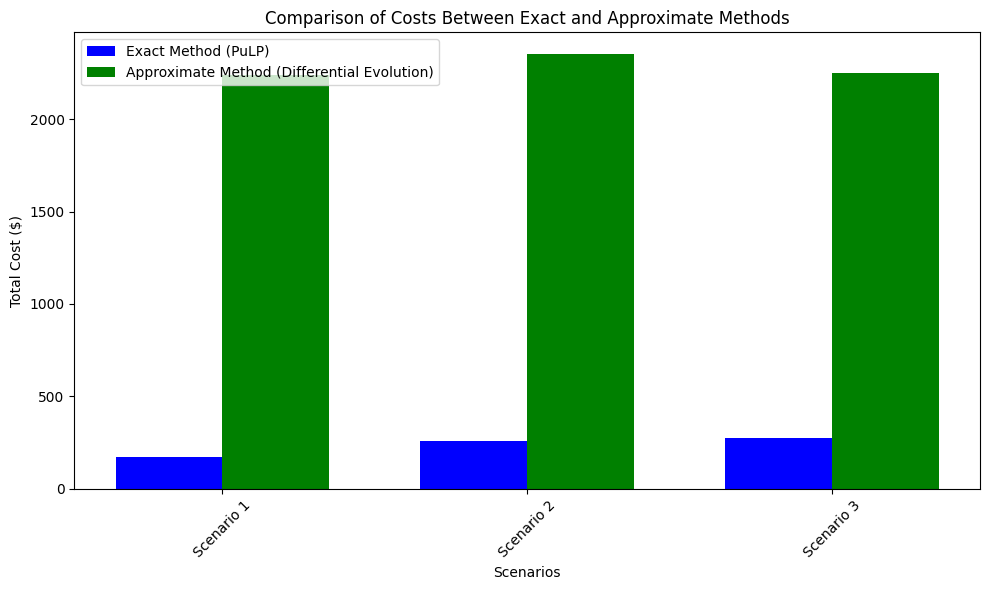

In [35]:

# Plot comparison of costs
plt.figure(figsize=(10, 6))
bar_width = 0.35
x = np.arange(len(nutritional_requirements))

plt.bar(x - bar_width / 2, exact_costs, bar_width, label="Exact Method (PuLP)", color="blue")
plt.bar(x + bar_width / 2, approx_costs, bar_width, label="Approximate Method (Differential Evolution)", color="green")

plt.xlabel("Scenarios")
plt.ylabel("Total Cost ($)")
plt.title("Comparison of Costs Between Exact and Approximate Methods")
plt.xticks(x, [f"Scenario {i+1}" for i in range(len(nutritional_requirements))], rotation=45)
plt.legend()

plt.tight_layout()
plt.show()

